# EXEMPLO TRANSFERÊNCIA DE CALOR 1D TRANSIENTE

A equação de transferência de calor unidimensional transiente, considerando difusividade térmica contante, é dada abaixo.

$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$

Para obter a resposta em regime permanente ($\partial u / \partial t =0$) basta resolver a equação homogênea 

$$ \frac{\partial^2 u}{\partial x^2} = 0$$

A solução, portanto, é uma reta, cujos coeficientes são determinados pelas condições de contorno. Para o caso de um material de espessura *e* com temperatura mantida constante nas paredes, a variação da temperatura ao longo do material é linear e passa pelas temperaturas das extremidades.

Resolvendo o problema numericamente, utilizando diferenças progressivas (Euler Forward) para o termo que varia no tempo, obtém-se

$$ \frac{u_k^{n+1}-u_k^n}{\Delta t} = \alpha\left[\frac{u_{k+1}^n-2u_k^n+u_{k-1}^n}{(\Delta x)^2}\right]$$

$$ u_k^{n+1}-u_k^n = \frac{\alpha\Delta t}{(\Delta x)^2} [u_{k+1}^n-2u_k^n+u_{k-1}^n] $$

Sendo o número de Fourier

$$ Fo = \frac{\alpha\Delta t}{(\Delta x)^2} $$

então

$$ u_k^{n+1} = u_k^n + Fo(u_{k+1}^n-2u_k^n+u_{k-1}^n) $$

Vamos implementar o algoritmo e verificar a estabilidade para diferentes *Fo*.

Explorar aplicativo disponível em https://gborelli-eng.shinyapps.io/heattransfer1d/


In [1]:
# Apenas reduzindo o tamanho dos gráficos...
require(repr)
options(repr.plot.width=7, repr.plot.height=5)

funGamma <-function(deltat, deltax, alpha){
    gamma <- alpha*deltat/(deltax^2)
    return(gamma)
}

gerarMatrizes <- function(deltat, extremidades=c(30,10), deltax=5, alpha=1, L=30){
    
    # número de nós
    nn <- L/deltax + 1
    nmid <- nn - 2
    
    gamma <- funGamma(deltat=deltat, deltax=deltax, alpha=alpha)
    A <- toeplitz(c(1-2*gamma, gamma, rep(0, nmid-2)))
    ucont <- cbind(c(extremidades[1]*gamma, rep(0, nmid-2), extremidades[2]*gamma))
    
    return(list(A=A, ucont=ucont, gamma=gamma, ext=extremidades))
}

# Resposta calculada de duas formas: matricial ou utilizando loop
calcResp <- function(M, u0, steps){

    n <- length(u0)
    
    # Matricial
    respA <- cbind(u0[2:(n-1)])
    for(i in 1:steps){
        respA <- M$A%*%respA + M$ucont
    }
    
    respA <- c(M$ext[1], respA, M$ext[2])

    # Loop
    respB <- u0
    respB[1] <-M$ext[1]
    respB[n] <- M$ext[2]
    for(i in 1:steps){
        rtempB <- respB
        for(k in 2:(n-1)){
            kplus <- k+1
            kminus <- k-1
            respB[k] <- rtempB[k] + M$gamma*(rtempB[kplus] - 2*rtempB[k] + rtempB[kminus])
        }
    }
    
    resp <- cbind(respA, respB)
    return(resp)
    
}

Loading required package: repr


In [2]:
A <- gerarMatrizes(deltat=2, alpha=5)
u0 <- c(30,rep(10,6))

In [3]:
st <- round(seq(1,20, length.out = 6))
res <- lapply(st, calcResp, M=A, u0=u0)

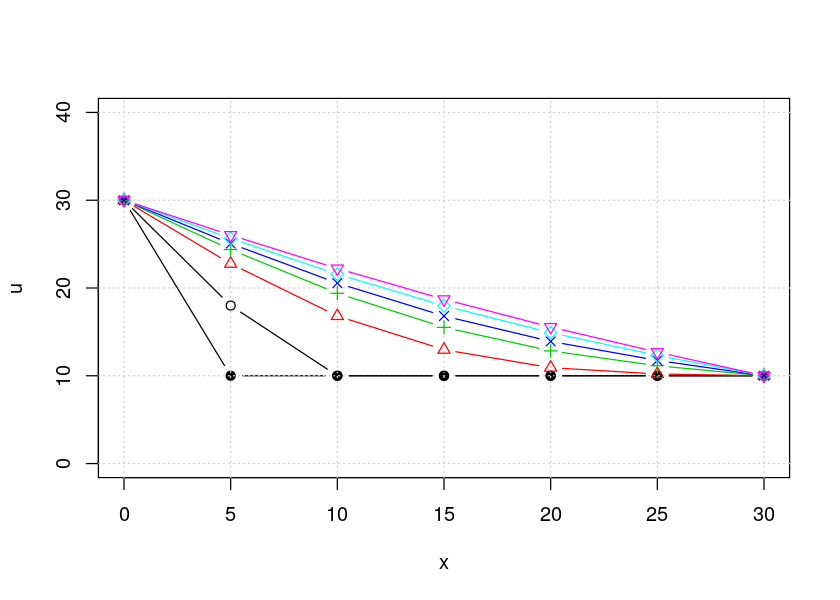

In [4]:
x <- seq(0,30,by=5)
plot(x, u0, t='b', ylim=c(0,40), pch=19, ylab='u')
grid()
for(i in 1:6){
    points(x, res[[i]][,1], col=i, t='b', pch=i)
}